In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
import pixiedust

Pixiedust database opened successfully


# Solving ODEs

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [2]:
Xe1 = np.arange(0,1,0.1) + 1e-6
Xe1 = Xe1.reshape((Xe1.shape[0],1,1))

The trial solution for this case is $\Psi(x)=1 + x N(x)$.
The first function below is the function $A(x)=1$
and the second function is the function $B(x)=x$.

In [3]:
def example1_initial_value(point):
  return 1

In [4]:
def example1_boundary_vanishing(point):
  return point

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [5]:
def example1_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - point ** 2 *(1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [6]:
def example1_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [7]:
def example1_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
      point * db_DN[0, 0, m] + db_N[0, 0, m] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * db_N[0, 0, m])
  return db

In [8]:
def example1_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
        point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dH_N[0, 0, m, p])
  return dH

In [9]:
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [10]:
example1_trial_solution = nnde.TrialSolution(loss_function=example1_loss_function,
                                        loss_function_single_point=example1_loss_function_single_point,
                                        bias_change=example1_bias_change,
                                        hidden_weights_change=example1_hidden_weights_change,
                                        visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [11]:
example1_trial_solution.train(Xe1, 100)

Epoch: 1 Loss function: 8.197887913724518
Epoch: 2 Loss function: 1.1460515718355655
Epoch: 3 Loss function: 0.7221887638126617
Epoch: 4 Loss function: 0.5738534962399705
Epoch: 5 Loss function: 0.4973431900519184
Epoch: 6 Loss function: 0.45130179634271667
Epoch: 7 Loss function: 0.42026557467596515
Epoch: 8 Loss function: 0.39579525608825683
Epoch: 9 Loss function: 0.3754726100687232
Epoch: 10 Loss function: 0.3579722467848832
Epoch: 11 Loss function: 0.3414075105722797
Epoch: 12 Loss function: 0.3256570903324295
Epoch: 13 Loss function: 0.31069565536046295
Epoch: 14 Loss function: 0.2950279148832206
Epoch: 15 Loss function: 0.2799368790818043
Epoch: 16 Loss function: 0.265928765812644
Epoch: 17 Loss function: 0.2518603202052419
Epoch: 18 Loss function: 0.23864666346561766
Epoch: 19 Loss function: 0.22729121547553766
Epoch: 20 Loss function: 0.21751179162042014
Epoch: 21 Loss function: 0.20841506279802957
Epoch: 22 Loss function: 0.20066106629651942
Epoch: 23 Loss function: 0.1936748

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

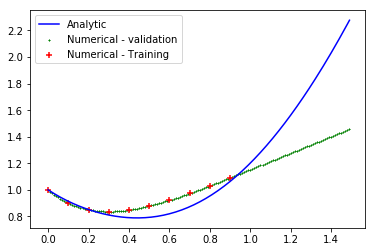

In [12]:
Xe1plot = np.arange(0,1.5, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical - validation', marker='x', s=1)
Ye12 = np.array([np.exp(-0.5*Xe1plot[i]**2)/(1+Xe1plot[i]+Xe1plot[i]**3) + Xe1plot[i]**2 for i in range(Xe1plot.shape[0])])
plt.plot(Xe1plot, Ye12, c='b', label='Analytic')
Ye1sol = np.array([example1_trial_solution.predict(Xe1[i]) for i in range(Xe1.shape[0])]).reshape((Xe1.shape[0],))
plt.scatter(Xe1.reshape((Xe1.shape[0],)), Ye1sol, c='r', label='Numerical - Training', marker='+', s=30)
plt.legend()
plt.show()

## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [13]:
Xe2 = np.arange(0,2,0.2) + 1e-6
Xe2 = Xe2.reshape((Xe2.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x N(x)$.
The first function below is the function $A(x)=0$
and the second function is the function $B(x)=x$.

In [14]:
def example2_initial_value(point):
  return 0

In [15]:
def example2_boundary_vanishing(point):
  return point

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [16]:
def example2_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + 0.2 * point * N - np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [17]:
def example2_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [18]:
def example2_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( point * db_DN[0, 0, m] + db_N[0, 0, m] + 0.2 * point * db_N[0, 0, m])
  return db

In [19]:
def example2_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * ( point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + 0.2 * point * dH_N[0, 0, m, p])
  return dH

In [20]:
def example2_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + 0.2 * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [21]:
example2_trial_solution = nnde.TrialSolution(loss_function=example2_loss_function,
                                        loss_function_single_point=example2_loss_function_single_point,
                                        bias_change=example2_bias_change,
                                        hidden_weights_change=example2_hidden_weights_change,
                                        visible_weights_change=example2_visible_weights_change,
                                        boundary_condition_value_function=example2_initial_value,
                                        boundary_vanishing_function=example2_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [22]:
example2_trial_solution.train(Xe2, 100)

Epoch: 1 Loss function: 0.09878618294734955
Epoch: 2 Loss function: 0.033519191469976756
Epoch: 3 Loss function: 0.014331704813076307
Epoch: 4 Loss function: 0.005945769493414348
Epoch: 5 Loss function: 0.0028787795100903004
Epoch: 6 Loss function: 0.0019629434729199215
Epoch: 7 Loss function: 0.00309617791193949
Epoch: 8 Loss function: 0.0015072899551728735
Epoch: 9 Loss function: 0.0016782752630100032
Epoch: 10 Loss function: 0.0016299644092348797
Epoch: 11 Loss function: 0.0022902188243355158
Epoch: 12 Loss function: 0.0022800449938937418
Epoch: 13 Loss function: 0.0017576518724682722
Epoch: 14 Loss function: 0.0012536702220684384
Epoch: 15 Loss function: 0.0013127387967209866
Epoch: 16 Loss function: 0.0014216209365943838
Epoch: 17 Loss function: 0.001259975751462654
Epoch: 18 Loss function: 0.0013843951991158844
Epoch: 19 Loss function: 0.0012297800175653775
Epoch: 20 Loss function: 0.0010865640311434894
Epoch: 21 Loss function: 0.0010740827076553485
Epoch: 22 Loss function: 0.001

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

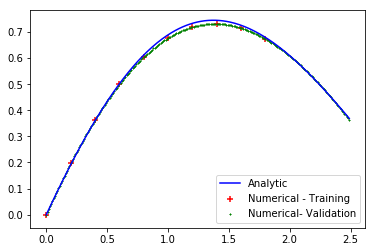

In [23]:
Ye2sol = np.array([example2_trial_solution.predict(Xe2[i]) for i in range(Xe2.shape[0])]).reshape((Xe2.shape[0],))
plt.scatter(Xe2.reshape((Xe2.shape[0],)), Ye2sol, c='r', label='Numerical - Training', marker='+', s=30)
Xe2plot = np.arange(0,2.5, 0.01)
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0], 1, 1))
Ye2 = np.array([example2_trial_solution.predict(Xe2plot[i]) for i in range(Xe2plot.shape[0])]).reshape((Xe2plot.shape[0],))
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0],))
Ye22 = np.array([np.exp(-0.2*Xe2plot[i]) * np.sin(Xe2plot[i]) for i in range(Xe2plot.shape[0])])
plt.scatter(Xe2plot, Ye2, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe2plot, Ye22, c='b', label='Analytic')
plt.legend()
plt.show()

## Example 3

$\frac{d^2}{dx^2}\Psi+\frac{1}{5}\frac{d}{dx}\Psi+\Psi=-\frac{1}{5}\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$, $\frac{d}{dx}\Psi(0)=1$ and domain $x\in[0,2]$

In [24]:
Xe3 = np.arange(0,2,0.2) + 1e-6
Xe3 = Xe3.reshape((Xe3.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x + x^2N(x)$.
The first function below is the function $A(x)=x$
and the second function is the function $B(x)=x^2$.

In [25]:
def example3_initial_value(point):
  return point

In [26]:
def example3_boundary_vanishing(point):
  return point ** 2

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [27]:
def example3_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  loss = ( 2 * N + 4 * point * dN + point ** 2 * d2N + 0.2 * (1 + 2 * point * N + point ** 2 * dN)
     + point + point ** 2 * N + 0.2 * np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [28]:
def example3_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [29]:
def example3_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( 2 * db_N[0, 0, m] + 4 * point * db_DN[0, 0, m] + point ** 2 * db_D2N[0, 0, m]
                              + 0.2 * (2 * point * db_N[0, 0, m] + point ** 2 * db_DN[0, 0, m])
                              + point ** 2 * db_N[0, 0, m] 
      )
  return db

In [30]:
def example3_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (2 * dH_N[0, 0, m, p] + 4 * point * dH_DN[0, 0, m, p] + point ** 2 * dH_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dH_N[0, 0, m, p] + point ** 2 * dH_DN[0, 0, m, p])
                              + point ** 2 * dH_N[0, 0, m, p]
      )
  return dH

In [31]:
def example3_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (2 * dV_N[0, 0, m, p] + 4 * point * dV_DN[0, 0, m, p] + point ** 2 * dV_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dV_N[0, 0, m, p] + point ** 2 * dV_DN[0, 0, m, p])
                              + point ** 2 * dV_N[0, 0, m, p]   
      )
  return dV

### Defining the trial solution with an apropiate network

In [32]:
example3_trial_solution = nnde.TrialSolution(loss_function=example3_loss_function,
                                        loss_function_single_point=example3_loss_function_single_point,
                                        bias_change=example3_bias_change,
                                        hidden_weights_change=example3_hidden_weights_change,
                                        visible_weights_change=example3_visible_weights_change,
                                        boundary_condition_value_function=example3_initial_value,
                                        boundary_vanishing_function=example3_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [33]:
example3_trial_solution.train(Xe3, 100)

FloatingPointError: underflow encountered in exp

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

In [ ]:
Ye3sol = np.array([example3_trial_solution.predict(Xe3[i]) for i in range(Xe3.shape[0])]).reshape((Xe3.shape[0],))
plt.scatter(Xe3.reshape((Xe3.shape[0],)), Ye3sol, c='r', label='Numerical - Training', marker='+', s=30)
Xe3plot = np.arange(0,2.5, 0.01)
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0], 1, 1))
Ye3 = np.array([example3_trial_solution.predict(Xe3plot[i]) for i in range(Xe3plot.shape[0])]).reshape((Xe3plot.shape[0],))
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0],))
Ye33 = np.array([np.exp(-0.2*Xe3plot[i]) * np.sin(Xe3plot[i]) for i in range(Xe3plot.shape[0])])
plt.scatter(Xe3plot, Ye3, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe3plot, Ye33, c='b', label='Analytic')
plt.legend()
plt.show()

In [ ]:
print(example3_trial_solution.network.hidden_layer.bias.min())
print(example3_trial_solution.network.hidden_layer.bias.max())
print(example3_trial_solution.network.hidden_layer.weights.min())
print(example3_trial_solution.network.hidden_layer.weights.max())
print(example3_trial_solution.network.visible_layer.weights.min())
print(example3_trial_solution.network.visible_layer.weights.max())